[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/map-reduce.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239947-lesson-3-map-reduce)

# Map-reduce

## Review

We're building up to a multi-agent research assistant that ties together all of the modules from this course.

To build this multi-agent assistant, we've been introducing a few LangGraph controllability topics.

We just covered parallelization and sub-graphs.

## Goals

Now, we're going to cover [map reduce](https://langchain-ai.github.io/langgraph/how-tos/map-reduce/).

In [10]:
from langchain_core.messages import SystemMessage



In [1]:
from dotenv import load_dotenv
import operator
from typing import Annotated, List
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END, START
from langgraph.types import Send
from pydantic import BaseModel

load_dotenv()

True

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [16]:
class F1RaceReportState(TypedDict):
    race_name: str
    sessions: List[str]
    summaries: Annotated[list, operator.add]
    final_report: str


class Sessions(BaseModel):

    sessions: List[str]

class Summary(BaseModel):

    summary: str

class FinalReport(BaseModel):

    report: str

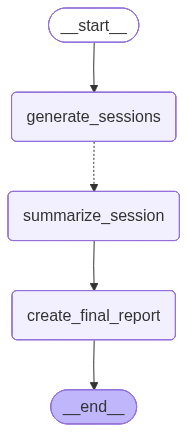

In [19]:
from IPython.core.display import Image

llm = ChatOpenAI(model="gpt-4o", temperature=0)
sys_message = SystemMessage("Whatever you wanna do do not use more than 100 to 150 words.")


def generate_sessions(state: F1RaceReportState):
    """
    Node 1: (Map) - Generates the list of sub-tasks.

    Takes the race name and identifies key sessions to analyze. This is the
    first step in the "map" phase.
    """
    prompt = f"Generate a list of 3 key sessions from the F1 race weekend for the '{state['race_name']}'. Examples include Qualifying, Sprint Race, or Main Race."
    input = [sys_message, prompt]

    response = llm.with_structured_output(Sessions).invoke(input)
    return {"sessions": response.sessions}


def summarize_session(state: dict):
    """
    Node 2: (Map) - This node is run in parallel for each session.

    It receives a single session and the race name, generates a summary,
    and appends it to the overall state's `summaries` list.
    """
    prompt = f"Provide a concise summary of the '{state['session']}' for the '{state['race_name']}'."
    input = [sys_message, prompt]
    response = llm.with_structured_output(Summary).invoke(input)
    return {"summaries": [response.summary]}


def create_final_report(state: F1RaceReportState):
    """
    Node 3: (Reduce) - Aggregates the parallel outputs into a final result.

    Takes all the individual summaries and synthesizes them into a single,
    cohesive report.
    """
    summaries_str = "\\n\\n".join(state["summaries"])

    prompt = f"Synthesize the following session summaries for the '{state['race_name']}' into a single, cohesive final report:\\n\\n{summaries_str}"
    input = [sys_message, prompt]

    response = llm.with_structured_output(FinalReport).invoke(input)
    return {"final_report": response.report}


def continue_to_summary(state: F1RaceReportState):
    """
    This function is used for conditional edging. It directs the graph to call
    the `summarize_session` node for each session identified. It uses `Send`
    to dynamically dispatch parallel tasks.
    """

    return [Send("summarize_session", {"session": s, "race_name": state["race_name"]}) for s in state["sessions"]]



workflow = StateGraph(F1RaceReportState)


workflow.add_node("generate_sessions", generate_sessions)
workflow.add_node("summarize_session", summarize_session)
workflow.add_node("create_final_report", create_final_report)


workflow.add_edge(START, "generate_sessions")
workflow.add_conditional_edges("generate_sessions", continue_to_summary, ["summarize_session"])
workflow.add_edge("summarize_session", "create_final_report")
workflow.add_edge("create_final_report", END)


graph = workflow.compile()
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [21]:
inputs = {"race_name": "2024 British Grand Prix"}



final_state = None
for s in graph.stream(inputs, stream_mode="values"):
    final_state = s
    print(s)
    print("---")


print("--- Final Race Report ---")
print(final_state["final_report"])

{'race_name': '2024 British Grand Prix', 'summaries': []}
---
{'race_name': '2024 British Grand Prix', 'sessions': ['Qualifying Session: Determines the starting grid for the main race, held on Saturday afternoon.', 'Sprint Race: A shorter race on Saturday that offers points and can impact the main race grid.', 'Main Race: The highlight event on Sunday, where drivers compete for the Grand Prix victory.'], 'summaries': []}
---
{'race_name': '2024 British Grand Prix', 'sessions': ['Qualifying Session: Determines the starting grid for the main race, held on Saturday afternoon.', 'Sprint Race: A shorter race on Saturday that offers points and can impact the main race grid.', 'Main Race: The highlight event on Sunday, where drivers compete for the Grand Prix victory.'], 'summaries': ["The qualifying session for the 2024 British Grand Prix is a crucial event held on Saturday afternoon, determining the starting positions for the main race. Drivers compete to set the fastest lap times, with the

## Studio

**⚠️ DISCLAIMER**

Since the filming of these videos, we've updated Studio so that it can be run locally and opened in your browser. This is now the preferred way to run Studio (rather than using the Desktop App as shown in the video). See documentation [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) on the local development server and [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server). To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the Studio UI: `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`.

Let's load our the above graph in the Studio UI, which uses `module-4/studio/map_reduce.py` set in `module-4/studio/langgraph.json`.